In [60]:
####Dependencies
import numpy as np
import pandas as pd
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import os
import rasterio
from shapely.geometry import box
import matplotlib.patches as patches

### Inputs

#### Total Inputs

In [44]:
# Input and output paths
input_folder = "./Input_Data/Biomass/NPP"
output_csv = "./Input_Data/Biomass/Total_Annual_NPP_Per_cell.csv"
output_csv1 = './Input_Data/Biomass/Total_Annual_NPP.csv'  

# Set Extent as per Grid and Cell size
extent = (95000, 6837000, 213000, 6917000)  # xmin, ymin, xmax, ymax
cell_size = 1000  # 1000m x 1000m cells
n_cells_x = int((extent[2] - extent[0]) / cell_size)  # Number of cells along x-axis
n_cells_y = int((extent[3] - extent[1]) / cell_size)  # Number of cells along y-axis
n_total_cells = n_cells_x * n_cells_y  # Total cells
crs = "EPSG:25833"

# Function to extract year from file name
def extract_year(filename):
    # Assumes the format NPP_<year>.tif
    return int(filename.split("_")[1].split(".")[0])

# Initialize a dictionary to store data
data = {"Cell_ID": np.arange(1, n_total_cells + 1)}

# Read each raster file
for file in os.listdir(input_folder):
    if file.endswith(".tif"):
        file_path = os.path.join(input_folder, file)
        year = extract_year(file)
        
        # Open the raster
        with rasterio.open(file_path) as src:
            # Check CRS
            if src.crs.to_string() != crs:
                raise ValueError(f"CRS of {file} does not match {crs}.")
            
            # Read raster data
            raster_data = src.read(1)  # Read the first band
            
            # Convert raster data from kg C/m² to tons
            raster_data_tons = raster_data.astype('float32')
            
            # Pad missing columns and rows with zeros
            padded_data = np.zeros((n_cells_y, n_cells_x), dtype=raster_data_tons.dtype)
            padded_data[:raster_data_tons.shape[0], :raster_data_tons.shape[1]] = raster_data_tons  # Fill existing data
            
            # Flatten the padded raster to 1D array
            raster_data_flat = padded_data.flatten()
            
            if len(raster_data_flat) != n_total_cells:
                raise ValueError(f"Raster {file} padded array length mismatch.")
            
            # Store the data for the year
            data[year] = raster_data_flat

# Convert data dictionary to DataFrame
df = pd.DataFrame(data)
# Drop the Cell_ID column and sum across rows for each year
npp_per_year = df.drop(columns=['Cell_ID']).sum(axis=0).reset_index()
# Rename columns for clarity
npp_per_year.columns = ['Year', 'Net_Primary_Production']
# Convert Year to integer (if necessary)
npp_per_year['Year'] = npp_per_year['Year'].astype(int)
# Save the results to a CSV
npp_per_year.to_csv(output_csv1, index=False)
print(f"Total_Annual_NPP successfully saved to {output_csv1}.")

mean_per_cell = df.iloc[:, 1:].mean(axis=1)
df['Mean_Annual']=mean_per_cell
# Save to CSV
df.to_csv(output_csv, index=False)
print(f"Total NPP per cell saved to: {output_csv}")


Total_Annual_NPP successfully saved to ./Input_Data/Biomass/Total_Annual_NPP.csv.
Total NPP per cell saved to: ./Input_Data/Biomass/Total_Annual_NPP_Per_cell.csv


### Storage

In [22]:
#### Forest Biomass Storage 
### An important simplification here is the non-concideration of forest age which can be better simulated using a stand growth model
# Basic wood densities (kg/m³) for each tree species (Rytter el al 2016) (https://www.silvafennica.fi/article/1660)
wood_densities = {
    'Norway Spruce': 350,
    'Scots Pine': 440,
    'Birch': 480
}

# Define Biomass Expansion Factors (BEFs) for each species 
# BEFs vary with stand age; here, we use average values from Lehtonen et al. (2004) (https://europepmc.org/article/AGR/IND43625617) 
# See also (FAO Appendix 5 Table 5 Working Paper 68 - https://www.fao.org/4/j2132s/J2132S18.htm)
BEFs = {
    'Norway Spruce': 1.3,  
    'Scots Pine': 1.2,     
    'Birch': 1.4           
}

# Average annual volume increment per hectare (m³/ha/year) for each species
annual_volume_increment = {
    'Norway Spruce': 20,  # Gizachew and Bruner 2011
    'Scots Pine': 15,     # Gizachew and Bruner 2011
    'Birch': 3.0           # Bergqvist 1999 (https://www.sciencedirect.com/science/article/pii/S0378112799000080)
}

# Area covered by each species 
forest_areas_km2 = {
    'Norway Spruce': 79.695616,  # Forest area in km² based on SR16 year 2022
    'Scots Pine': 265.40032,     # Forest area in km² based on SR16 year 2022
    'Birch': 289.188864          # Forest area in km² based on SR16 year 2022
}


km2_to_ha = 100  # 1 km² = 100 ha

# Below-ground biomass as a fraction of above-ground biomass
below_ground_fraction = 0.2

# Initialize a DataFrame to store annual biomass accumulation
years = range(2000, 2021)
biomass_data = pd.DataFrame(columns=['Year', 'Species', 'Above_Ground_Biomass_t', 'Below_Ground_Biomass_t', 'Total_Biomass_t'])

# Calculate annual biomass accumulation for each species
for species in wood_densities:
    for year in years:
        # Convert forest area from km² to ha
        area_ha = forest_areas_km2[species] * km2_to_ha
        # Calculate above-ground biomass increment per hectare (t/ha/year)
        agb_increment_per_ha = (annual_volume_increment[species] * wood_densities[species] * BEFs[species]) / 1000  # Convert kg to tons
        # Calculate total above-ground biomass increment (t/year)
        agb_total_increment = agb_increment_per_ha * area_ha
        # Calculate below-ground biomass increment (t/year)
        bgb_total_increment = agb_total_increment * below_ground_fraction
        # Total biomass increment (t/year)
        total_biomass_increment = agb_total_increment + bgb_total_increment
        # Append the results to the DataFrame
        biomass_data = biomass_data.append({
            'Year': year,
            'Species': species,
            'Above_Ground_Biomass_t': agb_total_increment,
            'Below_Ground_Biomass_t': bgb_total_increment,
            'Total_Biomass_t': total_biomass_increment
        }, ignore_index=True)

# Display the results
print(biomass_data)

# Save the results to a CSV file
biomass_data.to_csv('./Outputs/Biomass/annual_forest_biomass_stor.csv', index=False)
print("Biomass data saved to ./Outputs/Biomass/annual_forest_biomass_stor.csv")



    Year        Species  Above_Ground_Biomass_t  Below_Ground_Biomass_t  \
0   2000  Norway Spruce            72523.010560            14504.602112   
1   2001  Norway Spruce            72523.010560            14504.602112   
2   2002  Norway Spruce            72523.010560            14504.602112   
3   2003  Norway Spruce            72523.010560            14504.602112   
4   2004  Norway Spruce            72523.010560            14504.602112   
..   ...            ...                     ...                     ...   
58  2016          Birch            58300.474982            11660.094996   
59  2017          Birch            58300.474982            11660.094996   
60  2018          Birch            58300.474982            11660.094996   
61  2019          Birch            58300.474982            11660.094996   
62  2020          Birch            58300.474982            11660.094996   

    Total_Biomass_t  
0      87027.612672  
1      87027.612672  
2      87027.612672  
3      8702

C:\Users\zvirk20\AppData\Local\Temp\ipykernel_68844\326215036.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biomass_data = biomass_data.append({
C:\Users\zvirk20\AppData\Local\Temp\ipykernel_68844\326215036.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biomass_data = biomass_data.append({
C:\Users\zvirk20\AppData\Local\Temp\ipykernel_68844\326215036.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biomass_data = biomass_data.append({
C:\Users\zvirk20\AppData\Local\Temp\ipykernel_68844\326215036.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biomass_data = biomass_data.append({
C:\Users\zvirk20\AppData\Local\Temp\

In [23]:
#### Aquatic Biomass Storage

# Define water body characteristics
water_bodies = {
    'Lakes': {'area_km2': 15, 'avg_depth_m': 10},  # Example values, replace with actual data
    'Rivers': {'area_km2': 5, 'avg_depth_m': 5}   # Example values, replace with actual data
}

# Define biomass densities (average values, replace with actual data if available)
## Zoo-planktons, bentic invertebrates are not concidered
biomass_densities = {
    'phytoplankton': 50,  # mg/m^3 of water, based on chlorophyll-a (Algae)
    'macrophytes': 200,   # g/m^2 of surface area (Aquatic Plants)
    'fish': 10            # kg/ha of surface area
}

# Conversion factors
mg_to_kg = 1e-6
g_to_kg = 1e-3
km2_to_m2 = 1e6
km2_to_ha = 100

# Initialize a DataFrame to store annual biomass data
years = range(2000, 2021)
aquatic_biomass_data = pd.DataFrame(columns=['Year', 'Water_Body', 'Phytoplankton_t', 'Macrophytes_t', 'Fish_t', 'Total_Biomass_t'])

# Calculate biomass for each year and water body
for water_body, attributes in water_bodies.items():
    area_km2 = attributes['area_km2']
    avg_depth_m = attributes['avg_depth_m']

    # Convert area to m^2 and ha
    area_m2 = area_km2 * km2_to_m2
    area_ha = area_km2 * km2_to_ha

    for year in years:
        # Calculate phytoplankton biomass
        phytoplankton_t = (biomass_densities['phytoplankton'] * avg_depth_m * area_m2 * mg_to_kg)/ 1000 # phytoplankton biomass in tonnes

        # Calculate macrophyte biomass
        macrophytes_t = (biomass_densities['macrophytes'] * area_m2 * g_to_kg)/ 1000 # macrophytes biomass in tonnes

        # Calculate fish biomass
        fish_t = (biomass_densities['fish'] * area_ha)/ 1000 # fish biomass in tonnes

        # Total biomass
        total_biomass_t = phytoplankton_t + macrophytes_t + fish_t # Total biomass in tonnes

        # Append data to the DataFrame
        aquatic_biomass_data = aquatic_biomass_data.append({
            'Year': year,
            'Water_Body': water_body,
            'Phytoplankton_t': phytoplankton_t,
            'Macrophytes_t': macrophytes_t,
            'Fish_t': fish_t,
            'Total_Biomass_t': total_biomass_t
        }, ignore_index=True)

# Save the results to a CSV file
aquatic_biomass_data.to_csv('./Outputs/Biomass/annual_aquatic_biomass_stor.csv', index=False)

print("Aquatic biomass data saved to './Outputs/Biomass/annual_aquatic_Biomass_Storage.csv'")



Aquatic biomass data saved to './Outputs/Biomass/annual_aquatic_Biomass_Storage.csv'


C:\Users\zvirk20\AppData\Local\Temp\ipykernel_68844\282754226.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aquatic_biomass_data = aquatic_biomass_data.append({
C:\Users\zvirk20\AppData\Local\Temp\ipykernel_68844\282754226.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aquatic_biomass_data = aquatic_biomass_data.append({
C:\Users\zvirk20\AppData\Local\Temp\ipykernel_68844\282754226.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aquatic_biomass_data = aquatic_biomass_data.append({
C:\Users\zvirk20\AppData\Local\Temp\ipykernel_68844\282754226.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aquatic_biomass_data = aq

In [6]:
#### Crop Biomass Storage
## Here we are assuming the agricultural biomass storage to be negligble since, crop yield is collected and crop residue
# is also collected to be used for composting

In [7]:
### Grazed Biomass stored as Animals
# For simplification we are not estimating livestock since we have not included livestock water demand as well but it can be included as consumed biomass

#### Total Annual Storage

In [52]:
### Total Storage
# Input paths
aquatic_biomass_path = './Outputs/Biomass/annual_aquatic_biomass_stor.csv'
forest_biomass_path = './Outputs/Biomass/annual_forest_biomass_stor.csv'

# Output path
total_storage_path = './Outputs/Biomass/total_annual_storage.csv'

# Load datasets
aquatic_biomass = pd.read_csv(aquatic_biomass_path)[['Year', 'Total_Biomass_t']]
forest_biomass = pd.read_csv(forest_biomass_path)[['Year', 'Total_Biomass_t']]

# Rename columns for clarity
aquatic_biomass.rename(columns={'Total_Biomass_t': 'Aquatic_Biomass_t'}, inplace=True)
forest_biomass.rename(columns={'Total_Biomass_t': 'Forest_Biomass_t'}, inplace=True)

# Aggregate by Year to handle duplicates
aquatic_biomass = aquatic_biomass.groupby('Year', as_index=False).sum()
forest_biomass = forest_biomass.groupby('Year', as_index=False).sum()

# Merge datasets on Year and handle missing values
merged_biomass = pd.merge(aquatic_biomass, forest_biomass, on='Year', how='outer').fillna(0)

# Calculate Total Storage
merged_biomass['Total_Storage(t)'] = merged_biomass['Aquatic_Biomass_t'] + merged_biomass['Forest_Biomass_t']

# Select required columns and save to CSV
merged_biomass[['Year', 'Total_Storage(t)']].to_csv(total_storage_path, index=False)

print(f"Total storage saved to {total_storage_path}")

Total storage saved to ./Outputs/Biomass/total_annual_storage.csv


#### Total Storage per cell

In [54]:
#### Total Annual Storage Per Cell

# File Paths
forest_raster_path = './Input_Data/maps/for_area/for_ar.tif'
aquatic_raster_path = './Input_Data/maps/lakes&reservoirs/lake_res.tif'
forest_storage_file = './Outputs/Biomass/annual_forest_biomass_stor.csv'
aquatic_storage_file = './Outputs/Biomass/annual_aquatic_biomass_stor.csv'

# Output Paths
forest_storage_csv = './Outputs/Biomass/forest_biomass_stor_per_cell.csv'
aquatic_storage_csv = './Outputs/Biomass/aquatic_biomass_stor_per_cell.csv'

# Grid properties
n_cells_x = 118  # Number of columns (adjust based on grid)
n_cells_y = 80   # Number of rows (adjust based on grid)
n_total_cells = n_cells_x * n_cells_y

# Function to extract raster values as 1D array
def extract_raster_values(raster_path, no_data_value=255):
    with rasterio.open(raster_path) as src:
        data = src.read(1)  # Read the first band
        
        # Replace NaN values with 0
        data = np.nan_to_num(data, nan=0)
        
        # Replace no-data values (e.g., 255) with 0
        data[data == no_data_value] = 0
        
        return data.flatten()  # Flatten to 1D array (row-major order)

# Extract values for forest and aquatic rasters
forest_values = extract_raster_values(forest_raster_path, no_data_value=255)
aquatic_values = extract_raster_values(aquatic_raster_path, no_data_value=255)

# Ensure alignment with grid cell IDs
cell_ids = np.arange(1, n_total_cells + 1)
forest_df = pd.DataFrame({'Cell_ID': cell_ids, 'Value': forest_values})
aquatic_df = pd.DataFrame({'Cell_ID': cell_ids, 'Value': aquatic_values})

# Filter out zero values (non-forest and non-aquatic areas)
forest_df = forest_df[forest_df['Value'] > 0]
aquatic_df = aquatic_df[aquatic_df['Value'] > 0]

# Load annual storage data
forest_storage = pd.read_csv(forest_storage_file)
aquatic_storage = pd.read_csv(aquatic_storage_file)

def distribute_storage(cells_df, annual_storage, value_column):
    
    distributed = cells_df[['Cell_ID']].copy()
    
    for year, total_storage in annual_storage.groupby('Year')[value_column].sum().items():
        distributed[f'{year}'] = total_storage / len(cells_df)
    
    distributed['Mean_Storage'] = distributed.iloc[:, 1:].mean(axis=1)
    return distributed

# Distribute storage for forest (Total_Yield) and aquatic (Total_Biomass (t))
forest_distributed = distribute_storage(forest_df, forest_storage, 'Total_Biomass_t')
aquatic_distributed = distribute_storage(aquatic_df, aquatic_storage, 'Total_Biomass_t')

# Save results to CSV
forest_distributed.to_csv(forest_storage_csv, index=False)
aquatic_distributed.to_csv(aquatic_storage_csv, index=False)

print(f"Forest Biomass storage per cell saved to {forest_storage_csv}")
print(f"Aquatic Biomass storage per cell saved to {aquatic_storage_csv}")


Forest Biomass storage per cell saved to ./Outputs/Biomass/forest_biomass_stor_per_cell.csv
Aquatic Biomass storage per cell saved to ./Outputs/Biomass/aquatic_biomass_stor_per_cell.csv


In [29]:
### Total Storage
### Input paths
for_stor_csv = './Outputs/Biomass/forest_biomass_stor_per_cell.csv'
aq_stor_csv = './Outputs/Biomass/aquatic_biomass_stor_per_cell.csv'
### Output Path
Total_stor_csv = './Outputs/Biomass/total_biomass_stor_per_cell.csv'

# Load the data
for_stor = pd.read_csv(for_stor_csv)
aq_stor = pd.read_csv(aq_stor_csv)

# Initialize an empty DataFrame for the full range of Cell_IDs (1-9440)
cell_ids = pd.DataFrame({'Cell_ID': range(1, 9441)})


# Merge the data with the full Cell_ID range and fill missing values with 0
merged_stor = cell_ids.merge(for_stor[['Cell_ID', 'Mean_Storage']], on='Cell_ID', how='left') \
    .merge(aq_stor[['Cell_ID', 'Mean_Storage']], on='Cell_ID', how='left', suffixes=('_Forest', '_Aquatic'))


merged_stor.fillna(0, inplace=True)

# Calculate the total mean consumption
merged_stor['Total_Mean_Storage'] = merged_stor[['Mean_Storage_Forest', 'Mean_Storage_Aquatic']].sum(axis=1)

# Keep only the required columns
final_stor = merged_stor[['Cell_ID', 'Total_Mean_Storage']]

# Save the result to a CSV
final_stor.to_csv(Total_stor_csv, index=False)
print(f"Merged Storage data saved to {Total_stor_csv}")

Merged Storage data saved to ./Outputs/Biomass/total_biomass_stor_per_cell.csv


### Consumption

In [23]:
# File paths
et_file = './Input_Data/Meteo/DailyPETOtta.csv'
rainfall_file = './Input_Data/Meteo/Otta_Daily_Precip.csv'
output_file = './Outputs/Biomass/annual_crop_yield.csv'

# Read Climate Data
et_data = pd.read_csv(et_file, parse_dates=['Date'], dayfirst=True)
rainfall_data = pd.read_csv(rainfall_file, parse_dates=['Date'], dayfirst=True)

# To ensure consistent date range across datasets
date_range = pd.date_range(start='1990-01-01', end='2020-12-31')
et_data = et_data.set_index("Date").reindex(date_range).reset_index().rename(columns={"index": "Date"})
rainfall_data = rainfall_data.set_index("Date").reindex(date_range).reset_index().rename(columns={"index": "Date"})

# Effective Rainfall Using SCS Curve Number Method
def calculate_effective_rainfall(rainfall, curve_number):
    S = (25400 / curve_number) - 254  # Potential maximum retention (in mm)
    runoff = ((rainfall - 0.2 * S)**2) / (rainfall + 0.8 * S)
    runoff[rainfall <= 0.2 * S] = 0  # No runoff if rainfall is too low
    effective_rainfall = rainfall - runoff
    return np.maximum(effective_rainfall, 0)  # Avoid negative values

# Curve number for glacial till soil
curve_number = 75
rainfall_data["Effective_Rainfall"] = calculate_effective_rainfall(rainfall_data["P"], curve_number)

# Crop seasons and areas
crop_seasons = [
    {"Crop": "Potato", "Planting_Date": "2000-04-15", "Harvest_Date": "2000-09-21", "Area_ha": 92},
    {"Crop": "Barley", "Planting_Date": "2000-05-15", "Harvest_Date": "2000-09-11", "Area_ha": 112},
    {"Crop": "Grass", "Planting_Date": "2000-01-01", "Harvest_Date": "2000-12-31", "Area_ha": 5869},
]

# Crop-specific parameters
crops = {
    "Potato": {"Kc": 1.15, "Ky": 1.1, "HI": 0.75, "biomass_conversion": 10}, 
    "Barley": {"Kc": 1.15, "Ky": 1.0, "HI": 0.60, "biomass_conversion": 12},
    "Grass": {"Kc": 1.2, "Ky": 0.9, "HI": 0.60, "biomass_conversion": 15},
}

# Function to calculate seasonal biomass and yield
def calculate_seasonal_yield(crop_name, planting_date, harvest_date, crop_area_ha):
    crop_params = crops[crop_name]
    Kc = crop_params["Kc"]
    Ky = crop_params["Ky"]
    HI = crop_params["HI"]
    biomass_conversion = crop_params["biomass_conversion"]

    # Crop area to square meters
    crop_area_m2 = crop_area_ha * 10_000

    # Filter data for the crop growing season
    season_data = rainfall_data[
        (rainfall_data["Date"] >= pd.to_datetime(planting_date))
        & (rainfall_data["Date"] <= pd.to_datetime(harvest_date))
    ].copy()

    # ETc (mm) to m³
    season_data = season_data.reset_index(drop=True)
    season_data["ETc"] = et_data.loc[season_data.index, "PET"] * Kc  # PET to ETc (in mm)
    season_data["ETc_m3"] = (season_data["ETc"] * crop_area_m2) / 1000  # Convert to m³

    # Effective Rainfall (in mm) and converted to m³
    season_data["Effective_Rainfall_m3"] = (season_data["Effective_Rainfall"] * crop_area_m2) / 1000

    # Calculate water deficit in m³
    season_data["Water_Deficit_m3"] = season_data["ETc_m3"] - season_data["Effective_Rainfall_m3"]
    season_data["Water_Deficit_m3"] = season_data["Water_Deficit_m3"].clip(lower=0)

    # Total seasonal water consumption and deficit
    total_ETc_m3 = season_data["ETc_m3"].sum()
    total_water_deficit_m3 = season_data["Water_Deficit_m3"].sum()

    # Yield reduction factor
    yield_reduction = Ky * (total_water_deficit_m3 / total_ETc_m3) if total_ETc_m3 > 0 else 0

    # Biomass and yield calculation
    potential_biomass = total_ETc_m3 * biomass_conversion  # Biomass in kg
    actual_biomass = potential_biomass * (1 - yield_reduction)
    actual_yield = actual_biomass * HI

    # Condition for Grass: Crop residue = 10% of biomass
    if crop_name.lower() == "Grass":
        crop_residue = actual_biomass * 0.10
    else:
        crop_residue = actual_biomass - actual_yield  # Default calculation for other crops

    return {
        "Crop": crop_name,
        "Year": planting_date.split("-")[0],
        "Total_Yield (t)": actual_yield / 1000,  # Convert kg to tons
        "Total_Biomass (t)": actual_biomass / 1000,  # Convert kg to tons
        "Crop_Residue (t)": crop_residue / 1000,  # Convert kg to tons
    }

# Simulate yields for all years
results = []
for year in range(2000, 2021):
    for season in crop_seasons:
        planting_date = f"{year}-{season['Planting_Date'].split('-')[1]}-{season['Planting_Date'].split('-')[2]}"
        harvest_date = f"{year}-{season['Harvest_Date'].split('-')[1]}-{season['Harvest_Date'].split('-')[2]}"
        result = calculate_seasonal_yield(
            crop_name=season["Crop"],
            planting_date=planting_date,
            harvest_date=harvest_date,
            crop_area_ha=season["Area_ha"],
        )
        results.append(result)

# Save results to a CSV
results_df = pd.DataFrame(results)
results_df.to_csv(output_file, index=False)

print("Yield, biomass, and crop residue estimation completed. Results saved to", output_file)


Yield, biomass, and crop residue estimation completed. Results saved to ./Outputs/Biomass/annual_crop_yield.csv


In [29]:
#### Timber Yield
# File paths
biomass_csv = './Outputs/Biomass/annual_forest_biomass_stor.csv'
###Output Path
output_csv = './Outputs/Biomass/Annual_Timber_Yield.csv'

# Parameters for timber yield estimation
stem_fraction = {
    'Norway Spruce': 0.7,  # Proportion of AGB that is stem biomass
    'Scots Pine': 0.65,    # Proportion of AGB that is stem biomass
    'Birch': 0.6           # Proportion of AGB that is stem biomass
}

merchantable_fraction = {
    'Norway Spruce': 0.85,  # Usable part of the stem
    'Scots Pine': 0.8,      # Usable part of the stem
    'Birch': 0.75           # Usable part of the stem
}

recovery_rate = 0.8  # Efficiency of harvesting (80%) Assumed Efficiency Rate

# Load above-ground biomass data
biomass_data = pd.read_csv(biomass_csv)

# Initialize lists to store results
timber_yield_list = []
waste_list = []

# Calculate timber yield and waste for each row
for _, row in biomass_data.iterrows():
    species = row['Species']
    agb = row['Above_Ground_Biomass_t']

    # Calculate stem biomass
    stem_biomass = agb * stem_fraction.get(species, 0)

    # Calculate merchantable biomass
    merchantable_biomass = stem_biomass * merchantable_fraction.get(species, 0)

    # Calculate timber yield
    timber_yield = merchantable_biomass * recovery_rate
    timber_yield_list.append(timber_yield)

    # Calculate waste (non-recovered biomass)
    waste = merchantable_biomass * (1 - recovery_rate)
    waste_list.append(waste)

# Add results to the DataFrame
biomass_data['Timber_Yield_t'] = timber_yield_list
biomass_data['Wood_Chip_t'] = waste_list   ### This woodchip as well as crop residue will go to biomass plant (multiply tonnes x energy equivalent to get total production)
biomass_data['Total_Yield_t']=biomass_data['Timber_Yield_t']+ biomass_data['Wood_Chip_t']
# Save results to a new CSV file
biomass_data.to_csv(output_csv, index=False)

print(f"Timber yield and harvest waste data saved to {output_csv}")



Timber yield and harvest waste data saved to ./Outputs/Biomass/Annual_Timber_Yield.csv


#### Total Annual Consumption

In [24]:
#### Total Annual Consumption
# Input paths
crop_yield_path = './Outputs/Biomass/Annual_Crop_Yield.csv'
timber_yield_path = './Outputs/Biomass/Annual_Timber_Yield.csv'

# Output paths
total_consumption_path = './Outputs/Biomass/total_consumption.csv'
total_residue_path = './Outputs/Biomass/total_residue.csv'

# Load datasets
crop_yield = pd.read_csv(crop_yield_path)[['Year', 'Total_Biomass (t)', 'Crop_Residue (t)']]
timber_yield = pd.read_csv(timber_yield_path)[['Year', 'Timber_Yield_t', 'Wood_Chip_t']]

# Aggregate crop and timber data by year
crop_agg = crop_yield.groupby('Year').sum().reset_index()
timber_agg = timber_yield.groupby('Year').sum().reset_index()

# Merge and calculate totals
merged = pd.merge(crop_agg, timber_agg, on='Year', how='outer').fillna(0)
merged['Total_Consumption (t)'] = merged['Total_Biomass (t)'] + merged['Timber_Yield_t'] + merged['Wood_Chip_t']
merged['Total_Residue (t)'] = merged['Crop_Residue (t)'] + merged['Wood_Chip_t']

# Save outputs
merged[['Year', 'Total_Consumption (t)']].to_csv(total_consumption_path, index=False)
merged[['Year', 'Total_Residue (t)']].to_csv(total_residue_path, index=False)

print(f"Total consumption saved to {total_consumption_path}")
print(f"Total residue saved to {total_residue_path}")


Total consumption saved to ./Outputs/Biomass/total_consumption.csv
Total residue saved to ./Outputs/Biomass/total_residue.csv


#### Total Annual Consumption per cell

In [33]:
# File Paths
forest_raster_path = './Input_Data/maps/for_area/for_ar.tif'
agriculture_raster_path = './Input_Data/maps/agri_area/agri_ar.tif'
forest_consumption_file = './Outputs/Biomass/Annual_Timber_Yield.csv'
agriculture_consumption_file = './Outputs/Biomass/Annual_Crop_Yield.csv'

# Output Paths
forest_consumption_csv = './Outputs/Biomass/forest_biomass_con_per_cell.csv'
agriculture_consumption_csv = './Outputs/Biomass/ag_biomass_con_per_cell.csv'

# Grid properties
n_cells_x = 118  # Number of columns (adjust based on grid)
n_cells_y = 80   # Number of rows (adjust based on grid)
n_total_cells = n_cells_x * n_cells_y

# Function to extract raster values as 1D array
def extract_raster_values(raster_path, no_data_value=255):
    with rasterio.open(raster_path) as src:
        data = src.read(1)  # Read the first band
        
        # Replace NaN values with 0
        data = np.nan_to_num(data, nan=0)
        
        # Replace no-data values (e.g., 255) with 0
        data[data == no_data_value] = 0
        
        return data.flatten()  # Flatten to 1D array (row-major order)

# Extract values for forest and agriculture rasters
forest_values = extract_raster_values(forest_raster_path, no_data_value=255)
agriculture_values = extract_raster_values(agriculture_raster_path, no_data_value=255)

# Ensure alignment with grid cell IDs
cell_ids = np.arange(1, n_total_cells + 1)
forest_df = pd.DataFrame({'Cell_ID': cell_ids, 'Value': forest_values})
agriculture_df = pd.DataFrame({'Cell_ID': cell_ids, 'Value': agriculture_values})

# Filter out zero values (non-forest and non-agriculture areas)
forest_df = forest_df[forest_df['Value'] > 0]
agriculture_df = agriculture_df[agriculture_df['Value'] > 0]

# Load annual consumption data
forest_consumption = pd.read_csv(forest_consumption_file)
agriculture_consumption = pd.read_csv(agriculture_consumption_file)

def distribute_consumption(cells_df, annual_consumption, value_column):
    
    distributed = cells_df[['Cell_ID']].copy()
    
    for year, total_consumption in annual_consumption.groupby('Year')[value_column].sum().items():
        distributed[f'{year}'] = total_consumption / len(cells_df)
    
    distributed['Mean_Consumption'] = distributed.iloc[:, 1:].mean(axis=1)
    return distributed

# Distribute consumption for forest (Total_Yield) and agriculture (Total_Biomass (t))
forest_distributed = distribute_consumption(forest_df, forest_consumption, 'Total_Yield_t')
agriculture_distributed = distribute_consumption(agriculture_df, agriculture_consumption, 'Total_Biomass (t)')

# Save results to CSV
forest_distributed.to_csv(forest_consumption_csv, index=False)
agriculture_distributed.to_csv(agriculture_consumption_csv, index=False)

print(f"Forest Biomass consumption per cell saved to {forest_consumption_csv}")
print(f"Agriculture Biomass consumption per cell saved to {agriculture_consumption_csv}")




Forest Biomass consumption per cell saved to ./Outputs/Biomass/forest_biomass_con_per_cell.csv
Agriculture Biomass consumption per cell saved to ./Outputs/Biomass/ag_biomass_con_per_cell.csv


In [34]:
#####Merged Total Biomass Consumption
### Input paths
for_con_csv = './Outputs/Biomass/forest_biomass_con_per_cell.csv'
ag_con_csv = './Outputs/Biomass/ag_biomass_con_per_cell.csv'
### Output Path
Total_con_csv = './Outputs/Biomass/total_biomass_consumption_per_cell.csv'

# Load the data
for_con = pd.read_csv(for_con_csv)
ag_con = pd.read_csv(ag_con_csv)

# Initialize an empty DataFrame for the full range of Cell_IDs (1-9440)
cell_ids = pd.DataFrame({'Cell_ID': range(1, 9441)})

# Merge the data with the full Cell_ID range and fill missing values with 0
merged_con = cell_ids.merge(for_con[['Cell_ID', 'Mean_Consumption']], on='Cell_ID', how='left') \
    .merge(ag_con[['Cell_ID', 'Mean_Consumption']], on='Cell_ID', how='left', suffixes=('_Forest', '_Agriculture'))


merged_con.fillna(0, inplace=True)

# Calculate the total mean consumption
merged_con['Total_Mean_Consumption'] = merged_con[['Mean_Consumption_Forest', 'Mean_Consumption_Agriculture']].sum(axis=1)

# Keep only the required columns
final_con = merged_con[['Cell_ID', 'Total_Mean_Consumption']]

# Save the result to a CSV
final_con.to_csv(Total_con_csv, index=False)
print(f"Merged consumption data saved to {Total_con_csv}")

Merged consumption data saved to ./Outputs/Biomass/total_biomass_consumption_per_cell.csv


### Annual Balance

In [55]:
biomass_data_file = "./Input_Data/Biomass/Bioscape.xlsx"
total_annual_production_file = "./Input_Data/Biomass/Total_Annual_NPP.csv"
total_annual_storage_file = "./Outputs/Biomass/total_annual_storage.csv"
total_consumption_file = "./Outputs/Biomass/total_consumption.csv"
annual_balance_output_file = "./Outputs/Biomass/Annual_Biomass_Balance.csv"

# Read data
import_data = pd.read_excel(biomass_data_file, sheet_name="Imports")[['Year', 'Import(t)']]
export_data = pd.read_excel(biomass_data_file, sheet_name="Exports")[['Year', 'Export(t)']]
storage_data = pd.read_csv(total_annual_storage_file)
production_data = pd.read_csv(total_annual_production_file)
consumption_data = pd.read_csv(total_consumption_file)

# Filter years from 2000 to 2020
years = range(2000, 2021)

# Initialize the annual balance DataFrame
annual_balance = pd.DataFrame({"Year": years})


# Process import data
import_data_filtered = import_data[import_data["Year"].isin(years)]
annual_balance = annual_balance.merge(import_data_filtered, on="Year", how="left")
annual_balance.rename(columns={"Import(t)": "Import"}, inplace=True)

# Process export data
export_data_filtered = export_data[export_data["Year"].isin(years)]
annual_balance = annual_balance.merge(export_data_filtered, on="Year", how="left")
annual_balance.rename(columns={"Export(t)": "Export"}, inplace=True)

# Process storage data
storage_data_filtered = storage_data[storage_data["Year"].isin(years)]
annual_balance = annual_balance.merge(storage_data_filtered, on="Year", how="left")
annual_balance.rename(columns={"Total_Storage(t)": "Storage"}, inplace=True)

# Process consumption data
consumption_data_filtered = consumption_data[consumption_data["Year"].isin(years)]
annual_balance = annual_balance.merge(consumption_data_filtered, on="Year", how="left")
annual_balance.rename(columns={"Total_Consumption (t)": "Consumption"}, inplace=True)

# Process Net primary production data
production_data_filtered = production_data[production_data["Year"].isin(years)]
annual_balance = annual_balance.merge(production_data_filtered, on="Year", how="left")
annual_balance.rename(columns={"Net_Primary_Production": "Production"}, inplace=True)



# Save to CSV
annual_balance.to_csv(annual_balance_output_file, index=False)

print(f"Annual balance data saved to: {annual_balance_output_file}")

Annual balance data saved to: ./Outputs/Biomass/Annual_Biomass_Balance.csv


### Results Plotting

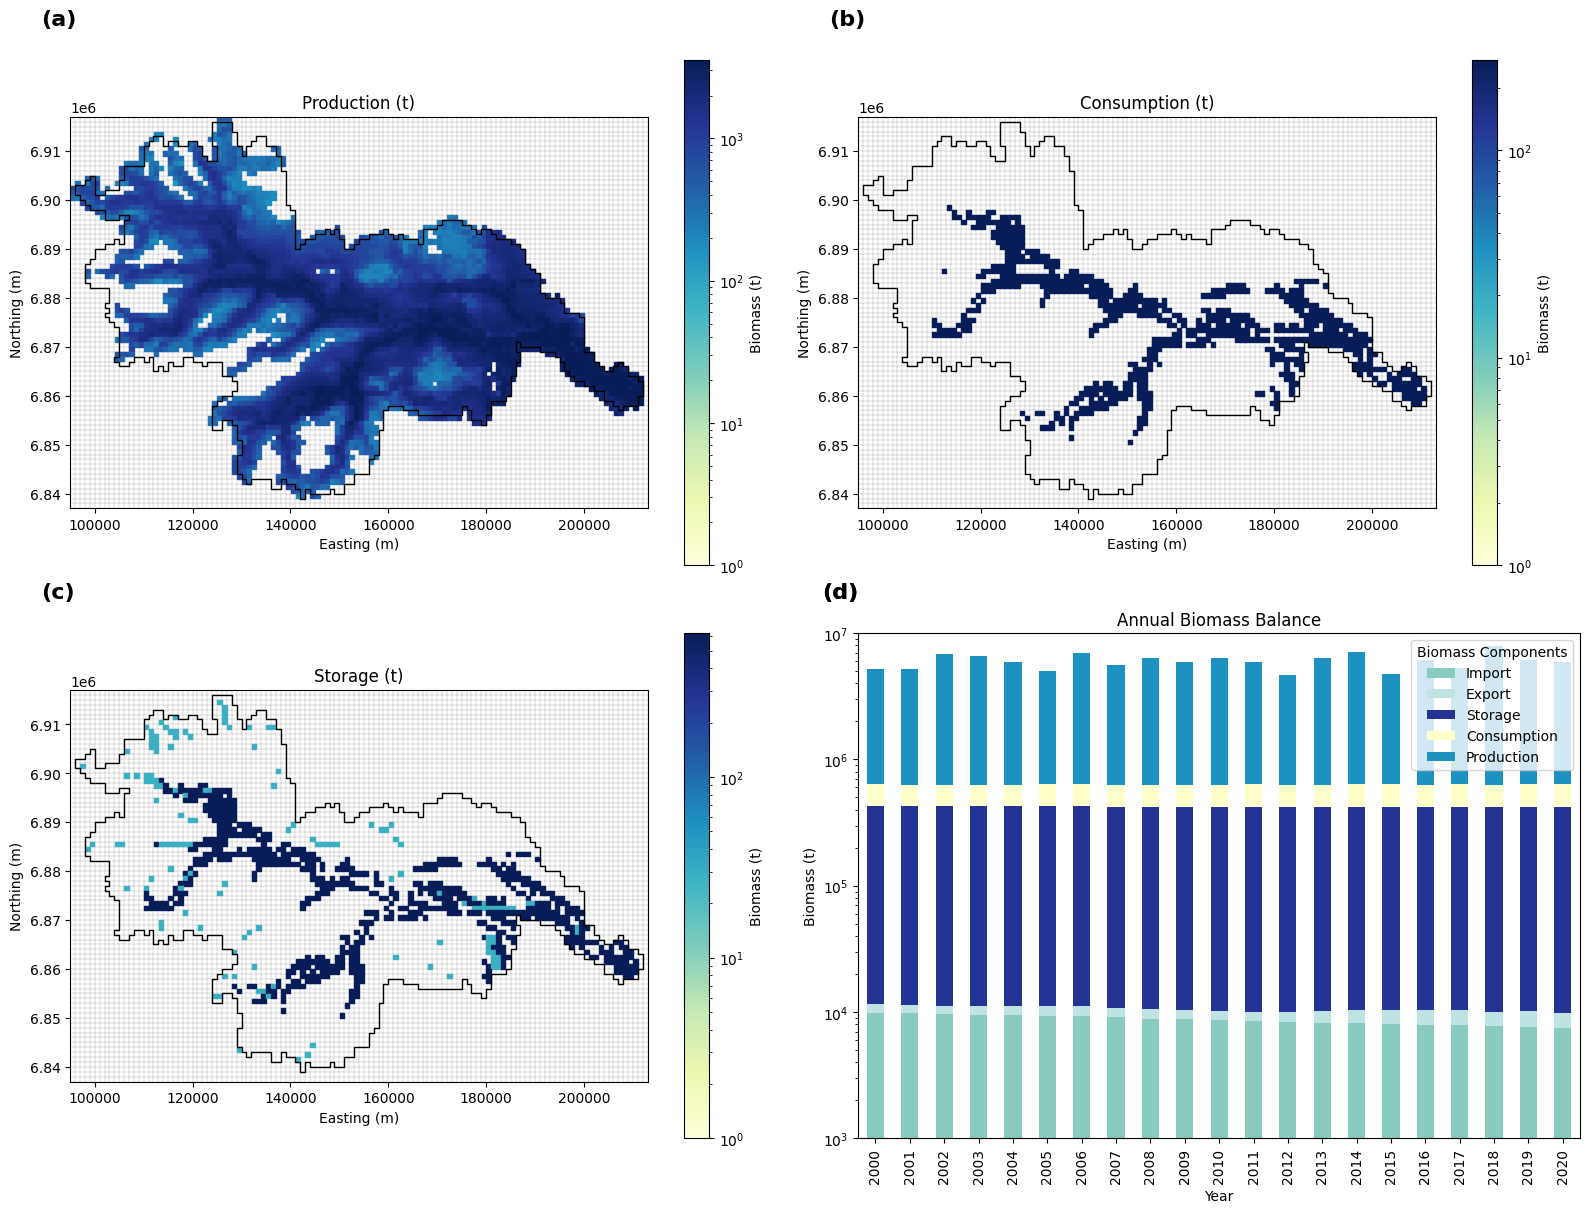

In [62]:
# Input file paths
grid_consumption_file = "./Outputs/Biomass/total_biomass_consumption_per_cell.csv"
grid_production_file = "./Input_Data/Biomass/Total_Annual_NPP_Per_cell.csv"
grid_storage_file = "./Outputs/Biomass/total_biomass_stor_per_cell.csv"
boundary_shapefile = "./Input_Data/maps/mask/Otta_mask.shp"
annual_balance_file = "./Outputs/Biomass/Annual_Biomass_Balance.csv"

# CRS and extent
crs = "EPSG:25833"
extent = [95000, 6837000, 213000, 6917000]
cell_size = 1000

# Load grid data
grid_consumption = pd.read_csv(grid_consumption_file, usecols=["Cell_ID", "Total_Mean_Consumption"])
grid_production = pd.read_csv(grid_production_file, usecols=["Cell_ID", "Mean_Annual"])
grid_storage = pd.read_csv(grid_storage_file, usecols=["Cell_ID", "Total_Mean_Storage"])

# Load boundary shapefile
boundary = gpd.read_file(boundary_shapefile).to_crs(crs)

# Load annual balance data
annual_balance = pd.read_csv(annual_balance_file)

# Create the grid geometry
n_cols = int((extent[2] - extent[0]) / cell_size)
n_rows = int((extent[3] - extent[1]) / cell_size)
grid_x, grid_y = np.meshgrid(
    np.linspace(extent[0] + cell_size / 2, extent[2] - cell_size / 2, n_cols),
    np.linspace(extent[3] - cell_size / 2, extent[1] + cell_size / 2, n_rows),
)
grid_cells = pd.DataFrame({
    "Cell_ID": range(1, n_cols * n_rows + 1),
    "X": grid_x.flatten(),
    "Y": grid_y.flatten(),
})

# Merge grid data with Cell_ID
consumption_grid = grid_cells.merge(grid_consumption, on="Cell_ID", how="left")
production_grid = grid_cells.merge(grid_production, on="Cell_ID", how="left")
storage_grid = grid_cells.merge(grid_storage, on="Cell_ID", how="left")

# Ensure no NaN values in merged data
consumption_grid["Mean_Consumption"] = consumption_grid["Total_Mean_Consumption"].fillna(0)
production_grid["Total_Production"] = production_grid["Mean_Annual"].fillna(0)
storage_grid["Total_Mean_Storage"] = storage_grid["Total_Mean_Storage"].fillna(0)

#__________________________________________________________________________


# Define consistent column-color mapping
column_color_map = {
    'Consumption': '#FFFFCC',   # Light Yellow
    'Import': '#89cbbf',        # Light Teal
    'Export': '#BFE3E3',        # Aqua Blue
    'Production': '#1D91C0', # Medium Blue
    'Storage': '#253494'        # Dark Blue
}

# Reorder colors for the bar plot
stacked_colors = [column_color_map[col] for col in annual_balance.columns if col != 'Year']

# Plot settings
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
titles = ["Production (t)", "Consumption (t)", "Storage (t)", "Annual Balance"]
data_grids = [
    (production_grid, "Mean_Annual"),
    (consumption_grid, "Total_Mean_Consumption"),
    (storage_grid, "Total_Mean_Storage")
]
panel_labels = ['(a)', '(b)', '(c)', '(d)']

# Grid settings (extent and size)
cell_size = 1000  # Grid cell size
grid_color = 'gray'  # Grid line color
grid_linewidth = 0.10  # Grid line thickness

# Function to add grid overlay
def add_grid_overlay(ax, grid_cells, cell_size):
    for _, row in grid_cells.iterrows():
        rect = patches.Rectangle(
            (row["X"] - cell_size / 2, row["Y"] - cell_size / 2),  # Bottom-left corner
            cell_size, cell_size,  # Width and height
            linewidth=grid_linewidth, edgecolor=grid_color, facecolor='none'
        )
        ax.add_patch(rect)


# Plot production, consumption, and storage maps with grid overlay
for i, (ax, (data_grid, col)) in enumerate(zip(axes.flat[:3], data_grids)):
    # Adjust color scaling with LogNorm for better visibility
    if data_grid[col].max() > 0:
        norm = LogNorm(vmin=max(data_grid[col].min(), 1), vmax=data_grid[col].quantile(0.99))
    else:
        norm = Normalize(vmin=0, vmax=1)
    # Add grid overlay
    add_grid_overlay(ax, data_grid, cell_size)
    # Plot grid data
    sc = ax.scatter(
        data_grid["X"], data_grid["Y"],
        c=data_grid[col],
        cmap='YlGnBu',  # Consistent color map for maps
        s=10,
        marker='s',
        norm=norm
    )
    # Plot formatting
    ax.set_title(titles[i])
    ax.set_xlim(extent[0], extent[2])
    ax.set_ylim(extent[1], extent[3])
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.text(
        -0.05, 1.275, panel_labels[i],
        transform=ax.transAxes, fontsize=16, fontweight='bold',
        va='top', ha='left', color='black'
    )

    # Overlay boundary
    boundary.plot(ax=ax, edgecolor="black", facecolor="none")
    fig.colorbar(sc, ax=ax, orientation="vertical", label="Biomass (t)")
    
    
# Annual balance 
ax = axes[1, 1]
annual_balance.set_index("Year").plot(
    kind="bar",
    stacked=True,
    ax=ax,
    title="Annual Biomass Balance",
    ylabel="Biomass (t)",
    xlabel="Year",
    color=stacked_colors
)
ax.text(
    -0.05, 1.10, panel_labels[3],
    transform=ax.transAxes, fontsize=16, fontweight='bold',
    va='top', ha='left', color='black'
)
ax.set_yscale('log')
ax.set_ylim(1e3, 1e7)  # Set limits to ensure small values are visible

# Add panel label
ax.text(
    -0.05, 1.10, panel_labels[3],
    transform=ax.transAxes, fontsize=16, fontweight='bold',
    va='top', ha='left', color='black'
)
ax.legend(loc='upper right',title="Biomass Components")

plt.tight_layout()
plt.savefig("./Results/Biomass_plot_with_grid.jpg", dpi=300, bbox_inches='tight')
plt.show()
